# Thai Classical Music Motif Analysis – Proof of Concept (Desc)





## 1. Data Loading & Corpus Overview
- Load JSON / MIDI-derived symbolic data  
- Basic stats (songs per motif, bars per song)

## 2. Symbolic Normalization
- Note vocabulary definition
- Rest handling
- Octave / ornament normalization
- Sequence flattening (bar → token stream)

## 3. Feature Extraction
### 3.1 Note-Level Statistics
- Pitch histogram
- Interval distribution

### 3.2 N-gram Extraction
- Unigram / Bigram / Trigram counts
- Per-motif aggregation

### 3.3 Contour Representation (optional)
- Up / Down / Same encoding
- Contour n-grams

## 4. Motif Similarity Analysis
- Feature vector construction
- Cosine / KL similarity
- Song-to-song and motif-level similarity

## 5. Motif Classification (Baseline)
- Train / validation split
- Linear models (LogReg / SVM)
- Confusion matrix & accuracy

## 6. Visualization
- N-gram heatmaps
- PCA / UMAP motif clustering

## 7. Discussion (Preliminary Findings)
- Observed motif patterns
- Limitations (small data, single layer)
- Implications for Stage 2 tagging

## 8. Next Steps
- Dataset expansion
- Audio features (MFCC / chroma)
- Conditional generation pipeline


#


# Thai Classical Music Motif Analysis – Code


## 0. Environment Setup (once per runtime)




In [1]:
!pip install mido python-rtmidi


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf


--2026-02-18 11:43:59--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2026-02-18 11:44:00--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00K   387KB/s    in 0.2s    

2026-02-18 11:44:02 (387 KB/s) - ‘th

In [ ]:
!git clone https://github.com/GetomG/Thai-Music-Thesis.git
# If already cloned:
# !git pull

In [ ]:
# Enter project folder
%cd Thai-Music-Thesis

In [3]:
!pwd

/Users/thanakrit/Documents/Thai Music Thesis


In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Properly load Sarabun font
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')

# Clear font cache to recognize new font
import matplotlib.font_manager as fm
fm.fontManager.addfont('thsarabunnew-webfont.ttf')

# Apply font globally
mpl.rcParams['font.family'] = 'TH Sarabun New'
mpl.rcParams["axes.unicode_minus"] = False

# For plots, ensure font is used
plt.rcParams['font.family'] = 'TH Sarabun New'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Helpers Libs


In [4]:
# ============================================================
# 2. I/O Utilities
# ============================================================
from thai_music_utils.io_utils import (
    save_json_bar_per_line
)

# ============================================================
# 3. Notation Processing
# - Flatten JSON → tokens
# - Normalize octave markers
# - Convert to continuous sequence string
# ============================================================
from thai_music_utils.notation_utils import (
    flatten_song_notation,
    normalize_octave_markers,
    notation_to_sequence
)

# ============================================================
# 4. Octave Inference (DP-based register guessing)
# ============================================================
from thai_music_utils.octave_inference import (
    is_thai_note,
    get_fixed_octave,
    guess_octaves_with_constraints,
    add_octaves_respecting_labels
)

# ============================================================
# 5. Preprocessing Utilities
# ============================================================
from thai_music_utils.preprocessing import (
    flatten_song_data,
    remove_all_signs
)

# ============================================================
# 6. MIDI Rendering (Ranad-specific)
# ============================================================
from thai_music_utils.midi_ranad import (
    generate_ranad_midi
)

# ============================================================
# 7. EDA Helpers (Symbolic Analysis)
# ============================================================
from thai_music_utils.eda_symbolic_normalization import (
    normalize_token,
    normalize_bar,
    flatten_song,
    THAI_NOTES,
    UP_MARK,
    LOW_MARK,
    REST_TOKEN
)

from thai_music_utils.eda_stats import (
    extract_symbols,
    pitch_stats,
    stats_to_df
)

## 1. Data Loading & Corpus Overview
- Load JSON / MIDI-derived symbolic data  
- Basic stats (songs per motif, bars per song)


In [8]:
import json
from pathlib import Path
from collections import defaultdict

# BASE = Path("/content/drive/MyDrive/thai_music_data/songs")
BASE = Path("./thai_music_data/songs")

songs = []

for motif_dir in BASE.iterdir():
    if not motif_dir.is_dir():
        continue

    motif = motif_dir.name

    for song_dir in motif_dir.iterdir():
        json_dir = song_dir / "json"
        if not json_dir.exists():
            continue

        for json_file in json_dir.glob("*.json"):
            try:
                with open(json_file, "r", encoding="utf-8") as f:
                    data = json.load(f)

                songs.append({
                    "motif": motif,
                    "song": song_dir.name,
                    "path": str(json_file),
                    "data": data
                })

            except Exception as e:
                print(f"⚠️ Skipped {json_file}: {e}")

In [6]:
print(f"Total songs loaded: {len(songs)}")

by_motif = defaultdict(int)
for s in songs:
    by_motif[s["motif"]] += 1

for motif, n in by_motif.items():
    print(f"{motif}: {n} songs")

Total songs loaded: 44
เขมร: 7 songs
จีน: 4 songs
พม่า: 5 songs
ลาว: 18 songs
ไทยเดิม: 2 songs
แขก: 8 songs


In [9]:
from pathlib import Path

# BASE = Path("/content/drive/MyDrive/thai_music_data/songs")

for motif_dir in BASE.iterdir():
    if not motif_dir.is_dir():
        continue

    for song_dir in motif_dir.iterdir():
        json_dir = song_dir / "json"
        if not json_dir.exists():
            continue

        json_files = sorted(p.name for p in json_dir.glob("*.json"))
        if not json_files:
            continue

        print(f"{motif_dir.name}/{song_dir.name}:")
        for jf in json_files:
            print(f"  - {jf}")

เขมร/เขมรโพธิสัตว์:
  - เขมรโพธิสัตว์_full.json
เขมร/เขมรไทรโยค:
  - เขมรไทรโยค_full.json
เขมร/เขมรพวง:
  - เขมรพวง_full.json
เขมร/เขมรลออองค์:
  - เขมรลออองค์_full.json
เขมร/เขมรปากท่อ:
  - เขมรปากท่อ_full.json
เขมร/เขมรชนบท:
  - เขมรชนบท_full.json
เขมร/เขมรพายเรือ:
  - เขมรพายเรือ_full.json
จีน/จีนฮ่อแห่:
  - จีนฮ่อแห่_full.json
จีน/จีนเก็บบุปผา:
  - จีนเก็บบุปผา_full.json
จีน/จีนไจ๋ยอ:
  - จีนไจ๋ยอ_full.json
จีน/จีนขิมเล็ก:
  - จีนขิมเล็ก_full.json
พม่า/พม่าเขว:
  - พม่าเขว_manual.json
พม่า/พม่ากลองยาว:
  - พม่ากลองยาว_manual.json
พม่า/พม่าปองเงาะ:
  - พม่าปองเงาะ_manual.json
พม่า/พม่าแปลง:
  - พม่าแปลง_full.json
พม่า/แร้งกระพือปีก:
  - แร้งกระพือปีก_manual.json
ลาว/ลาวกระทบไม้:
  - ลาวกระทบไม้_full.json
ลาว/ลาวกระแต:
  - ลาวกระแต_full.json
ลาว/ลาวเสี่ยงเทียน:
  - ลาวเสี่ยงเทียน_manual.json
ลาว/ลาวดวงดอกไม้:
  - ลาวดวงดอกไม้_manual.json
ลาว/ลาวเสี่ยงเทียน (เถา):
  - ลาวเสี่ยงเทียน (เถา)_full.json
ลาว/ลาวดำเนินทราย:
  - ลาวดำเนินทราย_manual.json
ลาว/ลาวจ้อย:
  - ลาวจ้อย_manual.json
ล

## 2. Symbolic Normalization (preprocessing)
- Note vocabulary definition
- Rest handling
- Octave / ornament normalization
- Sequence flattening (bar → token stream)


In [10]:
# ----------------------------
# Apply normalization to corpus
# ----------------------------
for s in songs:
    try:
        # Store normalized symbolic sequence WITHOUT overwriting raw data
        s["sequence"] = flatten_song(s["data"])
    except Exception as e:
        # Fault-tolerant: broken JSON → empty sequence
        print(f"⚠️ Normalization failed for {s['song']}: {e}")
        s["sequence"] = []


# ----------------------------
# Sanity check (inspect output)
# ----------------------------
songs[29]["sequence"][:40]

['----',
 '----',
 'มํซํรํ',
 'มํรํดํล',
 'ดํ',
 'ลลล',
 'มํซํรํ',
 'มํรํดํล',
 'ดํล',
 'ซมซล',
 'ดร',
 'มซ',
 'ล',
 'ซซซ',
 'ดํลซม',
 'ซรมซ',
 'ดํ',
 'ล',
 'ซม',
 'รด',
 'ลลล',
 'ซมซล',
 'ดํรํมํ',
 'รํดํ',
 '----',
 '----',
 'มํซํรํ',
 'มํรํดํล',
 'ดํ',
 'ลลล',
 'มํซํรํ',
 'มํรํดํล',
 'ดํล',
 'ซมซล',
 'ดร',
 'มซ',
 'ล',
 'ซซซ',
 'ดํลซม',
 'ซรมซ']

## 3. Feature Extraction



## 3.1 Note-Level Statistics
- Pitch histogram
- Interval distribution


### 3.1.1 Pitch / Symbol Histogram
We want to know which notes are used and how often.
- Count how often ด, ดํ, ซฺ, etc. appear
#### This tells us:
- register preference (high / low)
- stylistic bias per motif
- We split compound tokens like ซลดํล into individual notes
- Rests are ignored


In [11]:
# With octave information
pitch_with_octave = pitch_stats(songs, strip_octave=False)
df_pitch_with_octave = stats_to_df(pitch_with_octave)

# Without octave information
pitch_no_octave = pitch_stats(songs, strip_octave=True)
df_pitch_no_octave = stats_to_df(pitch_no_octave)

In [12]:
df_pitch_no_octave["ลาว"]

,note,count,percent
0,ซ,1144,23.783784
1,ด,1019,21.185031
2,ร,848,17.629938
3,ล,842,17.505198
4,ม,784,16.299376
5,ฟ,165,3.430353
6,ท,8,0.166320


In [13]:
df_pitch_no_octave["แขก"]

,note,count,percent
0,ร,929,20.047475
1,ม,869,18.752697
2,ซ,828,17.867933
3,ด,781,16.853690
4,ล,709,15.299957
5,ฟ,278,5.999137
6,ท,240,5.179111


In [14]:
df_pitch_no_octave["เขมร"]

,note,count,percent
0,ด,1172,23.070866
1,ฟ,1017,20.019685
2,ล,1001,19.704724
3,ซ,903,17.775591
4,ร,895,17.618110
5,ม,69,1.358268
6,ท,23,0.452756


In [15]:
df_pitch_no_octave["พม่า"]

,note,count,percent
0,ล,129,22.473868
1,ด,117,20.383275
2,ม,93,16.202091
3,ซ,89,15.505226
4,ร,82,14.285714
5,ท,34,5.923345
6,ฟ,30,5.226481


### 3.1.2 Interval Distribution


In [16]:
PITCH_ORDER = {
    "ซฺ": -3, "ลฺ": -2, "ทฺ": -1,
    "ด": 0, "ร": 1, "ม": 2, "ฟ": 3, "ซ": 4, "ล": 5, "ท": 6,
    "ดํ": 7, "รํ": 8, "มํ": 9, "ฟํ": 10, "ซํ": 11, "ลํ": 12,
}

In [17]:
def interval_bins(intervals):
    bins = {
        "Down step (-1)": 0,
        "Same (0)": 0,
        "Up step (+1)": 0,
        "Medium jump (2–3)": 0,
        "Large leap (≥4)": 0
    }

    for iv in intervals:
        if iv == -1:
            bins["Down step (-1)"] += 1
        elif iv == 0:
            bins["Same (0)"] += 1
        elif iv == 1:
            bins["Up step (+1)"] += 1
        elif abs(iv) in (2, 3):
            bins["Medium jump (2–3)"] += 1
        elif abs(iv) >= 4:
            bins["Large leap (≥4)"] += 1

    return bins

In [18]:
def extract_intervals(sequence):
    """
    Convert a symbolic sequence into signed pitch intervals
    using the PITCH_ORDER dict.
    """
    symbols = extract_symbols(sequence)
    intervals = []

    for a, b in zip(symbols, symbols[1:]):
        if a in PITCH_ORDER and b in PITCH_ORDER:
            intervals.append(PITCH_ORDER[b] - PITCH_ORDER[a])

    return intervals

In [19]:
interval_bin_pct_by_motif = {}

for motif in {s["motif"] for s in songs}:
    all_intervals = []
    for s in songs:
        if s["motif"] == motif:
            all_intervals.extend(extract_intervals(s["sequence"]))

    bins = interval_bins(all_intervals)
    total = sum(bins.values())

    interval_bin_pct_by_motif[motif] = {
        k: (v / total * 100 if total else 0)
        for k, v in bins.items()
    }

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grouped_vertical(interval_bin_pct_by_motif, title):

    motifs = list(interval_bin_pct_by_motif.keys())
    bins = list(next(iter(interval_bin_pct_by_motif.values())).keys())

    n_bins = len(bins)
    n_motifs = len(motifs)

    bar_width = 0.12   # 🔥 MUCH thinner
    x = np.arange(n_bins) * 1.1   # 🔥 add spacing between groups

    colors = plt.get_cmap("Set3").colors  # cleaner palette

    plt.figure(figsize=(14, 6))  # 🔥 wider figure

    for i, motif in enumerate(motifs):
        values = [interval_bin_pct_by_motif[motif][b] for b in bins]

        plt.bar(
            x + i * bar_width,
            values,
            width=bar_width,
            label=motif,
            color=colors[i],
            edgecolor="black",
            linewidth=0.4
        )

    plt.xticks(
        x + bar_width * (n_motifs - 1) / 2,
        bins,
        rotation=30
    )

    plt.ylabel("Percentage (%)")
    plt.title(title)
    plt.legend(frameon=False)
    plt.grid(axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

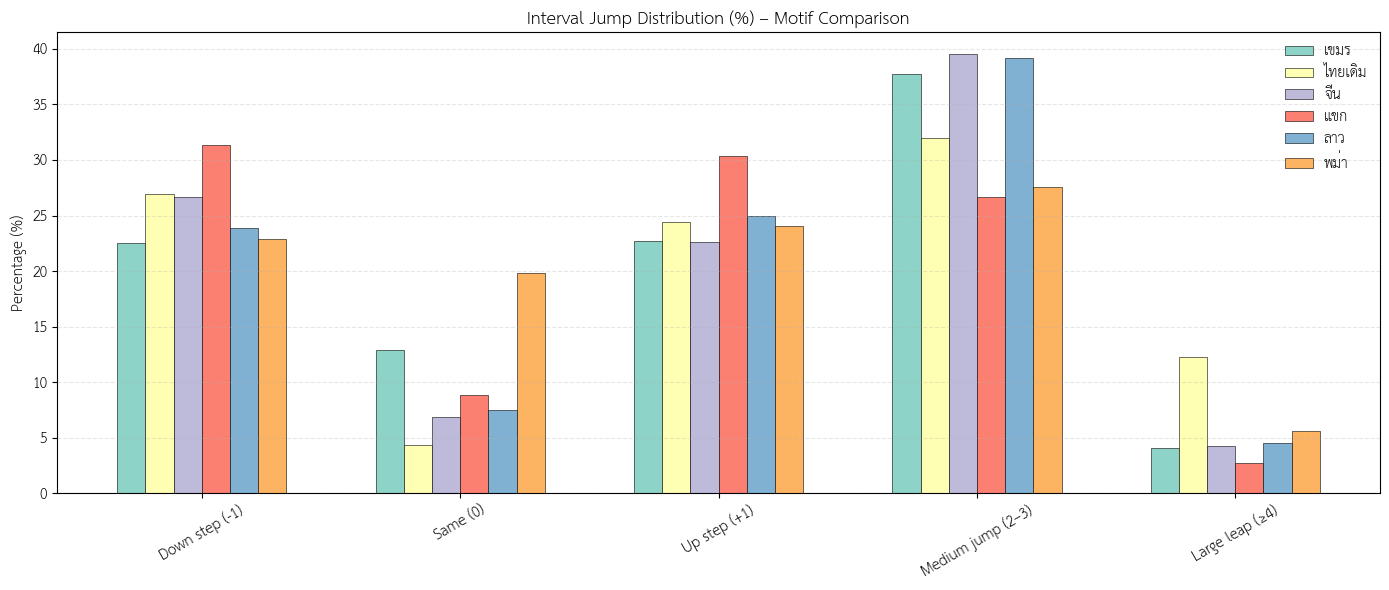

In [59]:
plot_grouped_vertical(
    interval_bin_pct_by_motif,
    "Interval Jump Distribution (%) – Motif Comparison"
)

In [22]:
import pandas as pd

rows = []

for motif, pct_bins in interval_bin_pct_by_motif.items():
    rows.append({
        "motif": motif,
        "stepwise_%": (
            pct_bins["Down step (-1)"]
            + pct_bins["Same (0)"]
            + pct_bins["Up step (+1)"]
        ),
        "medium_%": pct_bins["Medium jump (2–3)"],
        "large_%": pct_bins["Large leap (≥4)"],
    })

df_interval_bins = (
    pd.DataFrame(rows)
    .sort_values("motif")
    .reset_index(drop=True)
)

df_interval_bins = df_interval_bins.round(2)

df_interval_bins

,motif,stepwise_%,medium_%,large_%
0,จีน,56.18,39.56,4.26
1,พม่า,66.78,27.59,5.62
2,ลาว,56.30,39.16,4.53
3,เขมร,58.13,37.75,4.12
4,แขก,70.58,26.70,2.72
5,ไทยเดิม,55.75,31.97,12.28


## 3.2 N-grams


### 3.2.1 Symbol sequence construction
- We take each song and turn it into one linear sequence of symbols that n-grams can operate on.

- Future work may incorporate rest-aware segmentation, where extended rests are treated as phrase boundaries rather than melodic tokens.


In [23]:
def song_to_symbol_sequence(song, strip_octave=True):
    """
    Convert a song dict into a flat sequence of note symbols.
    """
    sequence = song["sequence"]  # already flattened bars
    symbols = extract_symbols(sequence, strip_octave=strip_octave)
    return symbols

In [24]:
s = songs[0]
seq = song_to_symbol_sequence(s)
seq[:30]

['ด',
 'ร',
 'ฟ',
 'ซ',
 'ฟ',
 'ฟ',
 'ล',
 'ซ',
 'ฟ',
 'ร',
 'ฟ',
 'ซ',
 'ฟ',
 'ฟ',
 'ล',
 'ด',
 'ร',
 'ด',
 'ร',
 'ฟ',
 'ซ',
 'ล',
 'ซ',
 'ฟ',
 'ร',
 'ฟ',
 'ซ',
 'ฟ',
 'ด',
 'ฟ']

In [25]:
for s in songs:
    s["symbol_sequence"] = song_to_symbol_sequence(s)

In [26]:
songs[0]["motif"], len(songs[0]["symbol_sequence"])

('เขมร', 1378)

### 3.2.2 Unigram Statistics (same as hist above)

- probably the same as histogram above

- This provides a baseline representation of melodic vocabulary and serves as a consistency check before moving to higher-order n-grams.


### 3.2.3 Bigram Statistics

- Bigram statistics count the frequency of consecutive pairs of note symbols in the symbolic sequence.

- This captures local melodic transition patterns and provides insight into motif-specific note-to-note grammar beyond individual pitch usage.


In [27]:
from collections import Counter

def extract_bigrams(symbol_sequence):
    """
    Convert a symbol sequence into bigrams.
    Example: ['ด','ร','ม'] -> [('ด','ร'), ('ร','ม')]
    """
    return zip(symbol_sequence, symbol_sequence[1:])

In [28]:
bigram_counts_by_motif = {}

for motif in {s["motif"] for s in songs}:
    counter = Counter()

    for s in songs:
        if s["motif"] == motif:
            counter.update(extract_bigrams(s["symbol_sequence"]))

    bigram_counts_by_motif[motif] = counter

In [29]:
import pandas as pd

df_bigram_by_motif = {}

for motif, counter in bigram_counts_by_motif.items():
    total = sum(counter.values())

    df = (
        pd.DataFrame([
            {
                "bigram": f"{a}→{b}",
                "count": cnt,
                "percent": cnt / total * 100
            }
            for (a, b), cnt in counter.items()
        ])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

    df_bigram_by_motif[motif] = df

In [30]:
def merge_topk_side_by_side(df_bigram_by_motif, top_k=15):

    merged = pd.DataFrame()

    for motif, df in df_bigram_by_motif.items():
        top = df.head(top_k).copy()
        top = top[["bigram", "percent"]]

        # round to 2 decimal places
        top["percent"] = top["percent"].round(2)

        top.columns = [
            f"{motif}_bigram",
            f"{motif}_%"
        ]

        merged = pd.concat([merged, top], axis=1)

    return merged


merged_df = merge_topk_side_by_side(df_bigram_by_motif, top_k=15)
merged_df

,เขมร_bigram,เขมร_%,ไทยเดิม_bigram,ไทยเดิม_%,จีน_bigram,จีน_%,แขก_bigram,แขก_%,ลาว_bigram,ลาว_%,พม่า_bigram,พม่า_%
0,ด→ร,7.98,ม→ร,7.54,ม→ร,8.93,ม→ร,8.52,ซ→ล,9.52,ซ→ล,7.38
1,ล→ด,7.83,ล→ซ,7.54,ร→ม,8.52,ร→ม,7.50,ล→ซ,7.87,ม→ม,6.68
2,ล→ซ,7.53,ซ→ล,7.42,ซ→ล,8.44,ร→ด,7.13,ม→ซ,7.85,ด→ด,6.68
3,ซ→ฟ,7.43,ม→ซ,6.78,ม→ซ,8.03,ซ→ล,6.94,ล→ด,7.72,ล→ซ,6.33
4,ร→ด,7.43,ร→ม,6.78,ล→ซ,7.53,ด→ร,6.72,ร→ด,7.51,ร→ด,5.80
5,ซ→ล,7.31,ซ→ม,6.65,ร→ด,7.13,ล→ซ,6.53,ด→ร,7.43,ด→ร,5.27
6,ด→ล,6.78,ร→ด,5.12,ล→ด,7.04,ซ→ม,4.45,ร→ม,6.93,ล→ด,4.57
7,ฟ→ร,6.31,ด→ร,4.86,ซ→ม,6.39,ม→ซ,4.13,ม→ร,6.74,ม→ร,4.57
8,ฟ→ซ,6.03,ล→ด,3.96,ด→ร,6.14,ด→ล,3.18,ซ→ม,6.41,ร→ม,4.04
9,ร→ฟ,5.68,ท→ล,3.58,ด→ล,4.75,ซ→ฟ,3.18,ด→ล,6.14,ล→ล,3.87


### 3.2.4 Trigram Statistics

- Trigram statistics count the frequency of three consecutive note symbols in the symbolic sequence.

- Trigrams capture short melodic phrases and local contour patterns, which are often more distinctive of motif style than single notes or pairwise transitions.


In [31]:
from collections import Counter

def extract_trigrams(symbol_sequence):
    """
    Convert a symbol sequence into trigrams.
    Example: ['ด','ร','ม','ซ'] -> [('ด','ร','ม'), ('ร','ม','ซ')]
    """
    return zip(symbol_sequence, symbol_sequence[1:], symbol_sequence[2:])

In [32]:
trigram_counts_by_motif = {}

for motif in {s["motif"] for s in songs}:
    counter = Counter()

    for s in songs:
        if s["motif"] == motif:
            counter.update(extract_trigrams(s["symbol_sequence"]))

    trigram_counts_by_motif[motif] = counter

In [33]:
import pandas as pd

df_trigram_by_motif = {}

for motif, counter in trigram_counts_by_motif.items():
    total = sum(counter.values())

    df = (
        pd.DataFrame([
            {
                "trigram": f"{a}→{b}→{c}",
                "count": cnt,
                "percent": cnt / total * 100
            }
            for (a, b, c), cnt in counter.items()
        ])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

    df_trigram_by_motif[motif] = df

In [34]:
def merge_topk_trigram_side_by_side(df_trigram_by_motif, top_k=15):

    merged = pd.DataFrame()

    for motif, df in df_trigram_by_motif.items():
        top = df.head(top_k).copy()
        top = top[["trigram", "percent"]]

        # round to 2 decimals
        top["percent"] = top["percent"].round(2)

        top.columns = [
            f"{motif}_trigram",
            f"{motif}_%"
        ]

        merged = pd.concat([merged, top], axis=1)

    return merged


merged_trigram_df = merge_topk_trigram_side_by_side(df_trigram_by_motif, top_k=15)
merged_trigram_df

,เขมร_trigram,เขมร_%,ไทยเดิม_trigram,ไทยเดิม_%,จีน_trigram,จีน_%,แขก_trigram,แขก_%,ลาว_trigram,ลาว_%,พม่า_trigram,พม่า_%
0,ล→ซ→ฟ,5.17,ล→ซ→ม,3.97,ม→ร→ด,5.75,ม→ร→ด,4.92,ม→ร→ด,5.17,ม→ม→ม,3.55
1,ฟ→ซ→ล,3.85,ซ→ม→ซ,3.33,ซ→ล→ด,4.68,ด→ร→ม,4.01,ซ→ล→ด,4.82,ล→ซ→ล,3.19
2,ด→ร→ฟ,3.57,ม→ซ→ล,3.08,ร→ม→ซ,4.27,ร→ด→ร,2.88,ด→ร→ม,4.46,ซ→ล→ด,2.84
3,ร→ด→ล,3.57,ซ→ม→ร,2.95,ม→ซ→ล,4.19,ร→ม→ร,2.71,ม→ซ→ล,4.02,ด→ด→ด,2.84
4,ซ→ล→ด,3.53,ร→ม→ซ,2.69,ด→ร→ม,4.19,ซ→ล→ซ,2.56,ล→ซ→ม,3.96,ม→ร→ด,2.66
5,ล→ด→ร,3.26,ร→ม→ร,2.69,ซ→ล→ซ,3.70,ด→ล→ซ,2.30,ซ→ล→ซ,3.81,ล→ด→ด,2.48
6,ด→ร→ด,3.14,ซ→ล→ซ,2.69,ล→ซ→ม,3.62,ล→ซ→ฟ,2.14,ซ→ม→ซ,3.67,ด→ด→ล,2.48
7,ซ→ฟ→ร,3.10,ซ→ล→ด,2.56,ซ→ม→ร,3.45,ซ→ม→ร,2.12,ด→ล→ซ,3.29,ซ→ม→ร,2.30
8,ฟ→ร→ด,2.96,ม→ร→ด,2.56,ร→ด→ล,3.04,ม→ร→ม,2.06,ร→ด→ล,3.18,ด→ร→ด,2.13
9,ด→ล→ด,2.92,ด→ร→ด,2.18,ร→ม→ร,2.96,ซ→ล→ด,1.97,ร→ม→ซ,2.97,ด→ร→ม,2.13


### 3.2.5 Quadgram Statistics


In [35]:
from collections import Counter

def extract_quadgrams(symbol_sequence):
    """
    Convert a symbol sequence into quadgrams.
    Example: ['ด','ร','ม','ซ','ล']
    -> [('ด','ร','ม','ซ'), ('ร','ม','ซ','ล')]
    """
    return zip(
        symbol_sequence,
        symbol_sequence[1:],
        symbol_sequence[2:],
        symbol_sequence[3:]
    )

In [36]:
quadgram_counts_by_motif = {}

for motif in {s["motif"] for s in songs}:
    counter = Counter()

    for s in songs:
        if s["motif"] == motif:
            counter.update(extract_quadgrams(s["symbol_sequence"]))

    quadgram_counts_by_motif[motif] = counter

In [37]:
import pandas as pd

df_quadgram_by_motif = {}

for motif, counter in quadgram_counts_by_motif.items():
    total = sum(counter.values())

    df = (
        pd.DataFrame([
            {
                "quadgram": f"{a}→{b}→{c}→{d}",
                "count": cnt,
                "percent": cnt / total * 100
            }
            for (a, b, c, d), cnt in counter.items()
        ])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

    df_quadgram_by_motif[motif] = df

In [38]:
def merge_topk_quadgram_side_by_side(df_quadgram_by_motif, top_k=15):

    merged = pd.DataFrame()

    for motif, df in df_quadgram_by_motif.items():
        top = df.head(top_k).copy()
        top = top[["quadgram", "percent"]]

        top["percent"] = top["percent"].round(2)

        top.columns = [
            f"{motif}_quadgram",
            f"{motif}_%"
        ]

        merged = pd.concat([merged, top], axis=1)

    return merged


merged_quad_df = merge_topk_quadgram_side_by_side(df_quadgram_by_motif, top_k=15)
merged_quad_df

,เขมร_quadgram,เขมร_%,ไทยเดิม_quadgram,ไทยเดิม_%,จีน_quadgram,จีน_%,แขก_quadgram,แขก_%,ลาว_quadgram,ลาว_%,พม่า_quadgram,พม่า_%
0,ล→ซ→ฟ→ร,2.29,ล→ซ→ม→ซ,2.44,ม→ร→ด→ล,2.56,ม→ร→ด→ร,2.30,ล→ซ→ม→ซ,2.78,ล→ซ→ล→ด,2.15
1,ด→ล→ซ→ฟ,2.02,ซ→ล→ซ→ม,1.54,ซ→ม→ร→ด,2.31,ร→ด→ร→ม,1.65,ร→ม→ร→ด,2.46,ล→ด→ด→ล,2.15
2,ร→ด→ล→ด,1.96,ม→ซ→ร→ม,1.41,ร→ม→ซ→ล,2.14,ซ→ม→ร→ด,1.48,ม→ซ→ล→ด,2.40,ด→ล→ซ→ล,1.61
3,ฟ→ซ→ล→ซ,1.92,ด→ล→ซ→ม,1.41,ม→ซ→ล→ด,2.14,ร→ม→ร→ด,1.41,ด→ล→ซ→ม,2.17,ล→ซ→ม→ร,1.43
4,ด→ร→ฟ→ซ,1.82,ม→ซ→ล→ด,1.41,ล→ซ→ม→ซ,2.06,ด→ร→ม→ร,1.39,ด→ร→ม→ร,2.04,ท→ล→ล→ล,1.43
5,ซ→ล→ด→ร,1.68,ล→ซ→ม→ร,1.29,ม→ซ→ล→ซ,2.06,ร→ม→ซ→ล,1.15,ซ→ม→ซ→ล,2.00,ด→ด→ล→ซ,1.43
6,ฟ→ร→ด→ล,1.60,ซ→ม→ร→ด,1.29,ด→ร→ม→ซ,1.90,ด→ม→ร→ด,1.13,ร→ด→ล→ด,1.87,ด→ล→ด→ด,1.43
7,ล→ด→ร→ด,1.54,ด→ร→ม→ร,1.29,ซ→ล→ซ→ม,1.73,ซ→ฟ→ม→ร,1.06,ม→ร→ด→ล,1.85,ซ→ม→ร→ด,1.43
8,ด→ร→ด→ล,1.48,ม→ซ→ล→ซ,1.29,ล→ซ→ล→ด,1.65,ล→ด→ล→ซ,1.04,ซ→ล→ด→ร,1.68,ด→ด→ด→ด,1.43
9,ซ→ล→ซ→ฟ,1.42,ร→ท→ล→ซ,1.29,ร→ด→ล→ซ,1.65,ร→ม→ฟ→ซ,1.02,ซ→ม→ร→ด,1.66,ร→ล→ท→ด,1.43


## 4. Feature vector building for Motifs cleaned

Each motif is represented by a fixed-dimensional feature vector 𝒛 that summarizes its symbolic melodic characteristics.

- The first part of 𝒛 encodes the octave-agnostic pitch distribution (ด, ร, ม, ฟ, ซ, ล, ท), capturing melodic vocabulary preferences.
- The second part of 𝒛 encodes interval magnitude statistics (stepwise, medium, large), capturing characteristic melodic motion patterns.

This compact representation enables direct quantitative comparison between motifs using standard similarity measures.


	1.	Base 7D (notes) + Directional interval stats (up / down / same)  → +3D
	2.	Interval entropy → +1D
	3.	Pitch-class entropy → +1D
	4.	Top-K pitch bigram frequencies → +K D (we’ll keep K small, e.g. 5–10)


### Helpers for Vectors


In [105]:
# ===== Pitch definitions =====
PITCH_ORDER = ["ด", "ร", "ม", "ฟ", "ซ", "ล", "ท"]

PITCH_TO_INT = {
    "ด": 0, "ร": 1, "ม": 2, "ฟ": 3, "ซ": 4, "ล": 5, "ท": 6,
}

# ===== Symbol helpers =====
from collections import Counter
import numpy as np


# Pitch statistics
def pitch_vector_from_symbols(symbols):
    counter = Counter(symbols)
    total = sum(counter.values())

    return [
        counter.get(n, 0) / total * 100 if total else 0
        for n in PITCH_ORDER
    ]

#Interval statistics (magnitude)
def interval_vector_from_symbols(symbols):
    intervals = []

    for a, b in zip(symbols, symbols[1:]):
        if a in PITCH_TO_INT and b in PITCH_TO_INT:
            intervals.append(PITCH_TO_INT[b] - PITCH_TO_INT[a])

    bins = {"stepwise": 0, "medium": 0, "large": 0}

    for iv in intervals:
        a = abs(iv)
        if a <= 1:
            bins["stepwise"] += 1
        elif a <= 3:
            bins["medium"] += 1
        else:
            bins["large"] += 1

    total = sum(bins.values())
    return [
        bins["stepwise"] / total * 100 if total else 0,
        bins["medium"] / total * 100 if total else 0,
        bins["large"] / total * 100 if total else 0,
    ]

#for V2
def directional_interval_stats(symbols):
    up = down = same = 0

    for a, b in zip(symbols, symbols[1:]):
        if a not in PITCH_TO_INT or b not in PITCH_TO_INT:
            continue

        ia = PITCH_TO_INT[a]
        ib = PITCH_TO_INT[b]

        if ib > ia:
            up += 1
        elif ib < ia:
            down += 1
        else:
            same += 1

    total = up + down + same
    if total == 0:
        return [0.0, 0.0, 0.0]

    return [
        up / total * 100,
        down / total * 100,
        same / total * 100,
    ]


#for V3
import math
from collections import Counter

def interval_entropy(symbols):
    """
    Shannon entropy of signed pitch intervals.
    """
    intervals = []
    for a, b in zip(symbols, symbols[1:]):
        if a in PITCH_TO_INT and b in PITCH_TO_INT:
            intervals.append(PITCH_TO_INT[b] - PITCH_TO_INT[a])

    if not intervals:
        return 0.0

    counter = Counter(intervals)
    total = sum(counter.values())

    entropy = 0.0
    for cnt in counter.values():
        p = cnt / total
        entropy -= p * math.log2(p)

    return entropy


# for V4
import math
from collections import Counter

def pitch_class_entropy(symbols):
    """
    Shannon entropy of pitch-class usage (octave-agnostic).
    """
    pitches = [s for s in symbols if s in PITCH_ORDER]
    if not pitches:
        return 0.0

    counter = Counter(pitches)
    total = sum(counter.values())

    entropy = 0.0
    for cnt in counter.values():
        p = cnt / total
        entropy -= p * math.log2(p)

    return entropy

#for V5
from collections import Counter

def extract_pitch_bigrams(symbols):
    """
    Extract pitch bigrams (order-sensitive, octave-agnostic).
    """
    pitches = [s for s in symbols if s in PITCH_ORDER]
    return list(zip(pitches, pitches[1:]))

def get_top_k_bigrams(songs, motifs, K=8):
    counter = Counter()

    for s in songs:
        if s["motif"] in motifs:
            bigrams = extract_pitch_bigrams(s["symbol_sequence"])
            counter.update(bigrams)

    return [bg for bg, _ in counter.most_common(K)]

### V1 (10D) BASE
  - **pitch** : dimensions 1–7 → what notes are used
  - **interval** : dimensions 8–10 → how melodies move


In [106]:
def motif_vector_v1(songs, motif):
    all_symbols = []
    for s in songs:
        if s["motif"] == motif:
            all_symbols.extend(s["symbol_sequence"])

    pitch_vec = pitch_vector_from_symbols(all_symbols)          #7D
    interval_vec = interval_vector_from_symbols(all_symbols)    #3D

    return np.array(pitch_vec + interval_vec)

In [107]:
motif_vectors_v1 = {
    motif: motif_vector_v1(songs, motif)
    for motif in {"ลาว", "เขมร", "แขก", "จีน", "พม่า"}  # filtered motifs
}

### V2 (13D)

- 7D **Pitch** (1–7): pitch-class usage (ด ร ม ฟ ซ ล ท)
- 3D **Interval** (8–10): stepwise / medium / large motion
- 3D **Direction** (11–13): up / down / same movement


In [108]:
def motif_vector_v2(songs, motif):
    base = motif_vector_v1(songs, motif)
    dir_vec = directional_interval_stats(   # +3D
        [sym for s in songs if s["motif"] == motif for sym in s["symbol_sequence"]]
    )
    return np.concatenate([base, dir_vec])

In [109]:
motif_vectors_v2 = {
    motif: motif_vector_v2(songs, motif)
    for motif in motif_vectors_v1
}

### V3 (14D)

- **Pitch** (1–7): pitch-class usage  
- **Interval** (8–10): stepwise / medium / large motion  
- **Direction** (11–13): up / down / same movement  
- **Interval entropy** (14): variability of interval usage


In [110]:
def motif_vector_v3(songs, motif):
    # base V2
    base = motif_vector_v2(songs, motif)

    # interval entropy
    all_symbols = [
        sym
        for s in songs if s["motif"] == motif
        for sym in s["symbol_sequence"]
    ]
    ent = interval_entropy(all_symbols)

    return np.concatenate([base, [ent]])


In [111]:
motif_vectors_v3 = {
    motif: motif_vector_v3(songs, motif)
    for motif in motif_vectors_v2
}

### V4 (15D)

- **Pitch** (1–7): pitch-class usage  
- **Interval** (8–10): stepwise / medium / large motion  
- **Direction** (11–13): up / down / same movement  
- **Interval entropy** (14): variability of interval usage  
- **Pitch-class entropy** (15): concentration vs spread of pitch usage


In [112]:
def motif_vector_v4(songs, motif):
    base = motif_vector_v3(songs, motif)

    all_symbols = [
        sym
        for s in songs if s["motif"] == motif
        for sym in s["symbol_sequence"]
    ]
    p_ent = pitch_class_entropy(all_symbols)

    return np.concatenate([base, [p_ent]])

In [113]:
motif_vectors_v4 = {
    motif: motif_vector_v4(songs, motif)
    for motif in motif_vectors_v3
}

### V5 (15 + K D)

- **Pitch** (1–7): pitch-class usage  
- **Interval** (8–10): stepwise / medium / large motion  
- **Direction** (11–13): up / down / same movement  
- **Interval entropy** (14): variability of interval usage  
- **Pitch-class entropy** (15): concentration of pitch usage  
- **Top-K pitch bigrams** (16–15+K): characteristic pitch transitions


In [114]:
MOTIFS_USED = list(motif_vectors_v4.keys())
TOP_K = 25

TOP_K_BIGRAMS = get_top_k_bigrams(songs, MOTIFS_USED, K=TOP_K)
TOP_K_BIGRAMS

[('ซ', 'ล'),
 ('ล', 'ซ'),
 ('ร', 'ด'),
 ('ด', 'ร'),
 ('ล', 'ด'),
 ('ม', 'ร'),
 ('ด', 'ล'),
 ('ร', 'ม'),
 ('ม', 'ซ'),
 ('ซ', 'ฟ'),
 ('ซ', 'ม'),
 ('ฟ', 'ซ'),
 ('ด', 'ด'),
 ('ฟ', 'ร'),
 ('ด', 'ซ'),
 ('ร', 'ฟ'),
 ('ล', 'ล'),
 ('ซ', 'ด'),
 ('ร', 'ร'),
 ('ซ', 'ซ'),
 ('ฟ', 'ฟ'),
 ('ด', 'ม'),
 ('ม', 'ม'),
 ('ร', 'ซ'),
 ('ล', 'ท')]

In [115]:
def bigram_vector_from_symbols(symbols, top_k_bigrams):
    bigrams = extract_pitch_bigrams(symbols)
    counter = Counter(bigrams)
    total = sum(counter.values())

    return [
        counter.get(bg, 0) / total * 100 if total else 0
        for bg in top_k_bigrams
    ]

In [116]:
def motif_vector_v5(songs, motif, top_k_bigrams):
    base = motif_vector_v4(songs, motif)

    all_symbols = [
        sym
        for s in songs if s["motif"] == motif
        for sym in s["symbol_sequence"]
    ]

    bg_vec = bigram_vector_from_symbols(all_symbols, top_k_bigrams)

    return np.concatenate([base, bg_vec])

In [117]:
motif_vectors_v5 = {
    motif: motif_vector_v5(songs, motif, TOP_K_BIGRAMS)
    for motif in motif_vectors_v4
}

### Cosine Sim V1 to V5 motifs to motifs


In [118]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# ===== Motif-level cosine similarity (V2) =====

motifs = list(motif_vectors_v2.keys())
X = np.vstack([motif_vectors_v2[m] for m in motifs])

sim_matrix = cosine_similarity(X)

df_similarity_v2 = pd.DataFrame(
    sim_matrix,
    index=motifs,
    columns=motifs
)

df_similarity_v2

,เขมร,จีน,แขก,ลาว,พม่า
เขมร,1.000000,0.962806,0.966802,0.971351,0.968956
จีน,0.962806,1.000000,0.989260,0.998354,0.976660
แขก,0.966802,0.989260,1.000000,0.987926,0.986667
ลาว,0.971351,0.998354,0.987926,1.000000,0.977500
พม่า,0.968956,0.976660,0.986667,0.977500,1.000000


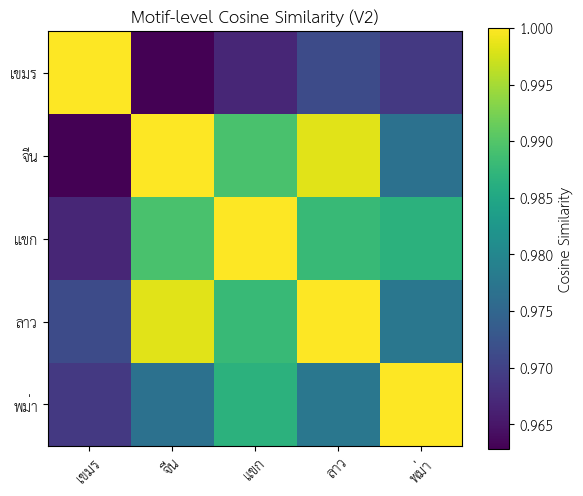

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(df_similarity_v2.values, cmap="viridis")
plt.colorbar(label="Cosine Similarity")

plt.xticks(range(len(motifs)), motifs, rotation=45)
plt.yticks(range(len(motifs)), motifs)

plt.title("Motif-level Cosine Similarity (V2)")
plt.tight_layout()
plt.show()

In [120]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# ===== Motif-level cosine similarity (V2) =====

motifs = list(motif_vectors_v5.keys())
X = np.vstack([motif_vectors_v5[m] for m in motifs])

sim_matrix = cosine_similarity(X)

df_similarity_v5 = pd.DataFrame(
    sim_matrix,
    index=motifs,
    columns=motifs
)

df_similarity_v5

,เขมร,จีน,แขก,ลาว,พม่า
เขมร,1.000000,0.945549,0.954144,0.958799,0.959372
จีน,0.945549,1.000000,0.986167,0.997486,0.969447
แขก,0.954144,0.986167,1.000000,0.984388,0.982599
ลาว,0.958799,0.997486,0.984388,1.000000,0.970912
พม่า,0.959372,0.969447,0.982599,0.970912,1.000000


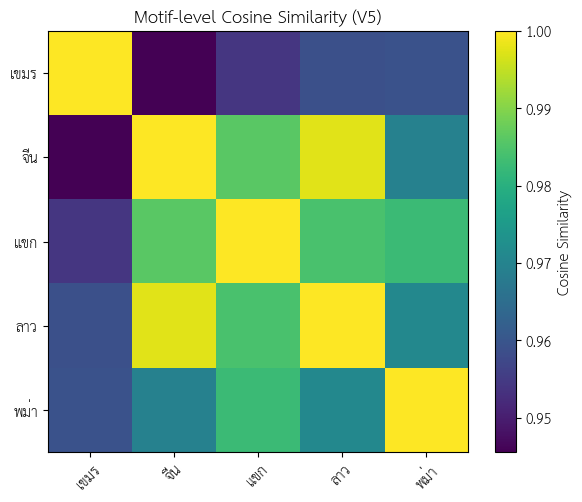

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.imshow(df_similarity_v5.values, cmap="viridis")
plt.colorbar(label="Cosine Similarity")

plt.xticks(range(len(motifs)), motifs, rotation=45)
plt.yticks(range(len(motifs)), motifs)

plt.title("Motif-level Cosine Similarity (V5)")
plt.tight_layout()
plt.show()

### Fragment Vectorization (for testing)


In [122]:
def get_fragment_symbols(song, n_symbols=16):
    return song["symbol_sequence"][:n_symbols]

def fragment_vector_v1(symbols):
    return np.array(
        pitch_vector_from_symbols(symbols)
        + interval_vector_from_symbols(symbols)
    )

def fragment_vector_v2(symbols):
    return np.concatenate([
        fragment_vector_v1(symbols),
        directional_interval_stats(symbols)
    ])

def fragment_vector_v3(symbols):
    base = fragment_vector_v2(symbols)
    ent = interval_entropy(symbols)
    return np.concatenate([base, [ent]])

def fragment_vector_v4(symbols):
    base = fragment_vector_v3(symbols)
    p_ent = pitch_class_entropy(symbols)
    return np.concatenate([base, [p_ent]])

def fragment_vector_v5(symbols, top_k_bigrams):
    base = fragment_vector_v4(symbols)
    bg_vec = bigram_vector_from_symbols(symbols, top_k_bigrams)
    return np.concatenate([base, bg_vec])

### Cosine Similarity demo with fragment






In [123]:
from sklearn.metrics.pairwise import cosine_similarity

def rank_fragment(fragment_vec, motif_vectors):
    return sorted(
        {
            motif: cosine_similarity(
                fragment_vec.reshape(1, -1),
                vec.reshape(1, -1)
            )[0, 0]
            for motif, vec in motif_vectors.items()
        }.items(),
        key=lambda x: x[1],
        reverse=True
    )

In [124]:
raw_frag = [ "--ดํล", "ดํลรํดํ", "--ฟร", "ฟรซฟ", "--ดํล", "--รํดํ", "ฟรซฟ", "ลซดํล" ] #khmer เขมร
frag = extract_symbols(raw_frag, strip_octave=True)

In [125]:
raw_frag = [ "ดํรํดํล", "ดํซลดํ", "ดํรํดํล", "ดํลซฟ", "----", "ดรฟซ", "ลฟลซ", "-ฟ-ร" ] #khmer เขมร
frag = extract_symbols(raw_frag, strip_octave=True)


In [126]:
raw_frag = [ "----", "----", "-ซ-ล", "-ท-ดํ", "---ท", "--ดํรํ", "มํรํดํท", "ดํรํ-ดํ" ] #แขก
frag = extract_symbols(raw_frag, strip_octave=True)

In [127]:
raw_frag = ["-รซล", "ทดํรํ", "--ดํมํ", "รํดํทล", "ทลซดํ", "-ท-ล", "ทลซล", "ซฟมฟ" ] 
frag = extract_symbols(raw_frag, strip_octave=True)

In [128]:
raw_frag = [ "----", "----", "--ซล", "ดํมรด", "รม-ซ", "-ล--", "ดํลซม", "ซล-ดํ","รํมํรํดํ" ] #ลาว correct
frag = extract_symbols(raw_frag, strip_octave=True)

In [129]:
raw_frag = [
          "----",
          "รมซล",
          "ซลดํล",
          "-ซซซ",
          "-ดรม",
          "-ซ-ล",
          "-ดํ-มํ",
          "-รํมํซํ"
        ] #ลาว  correct
frag = extract_symbols(raw_frag, strip_octave=True)

In [130]:
raw_frag =[
          "ดํลซม",
          "-ร-ด",
          "--มร",
          "ดร-ม",
          "รด-ร",
          "-ม-ซ",
          "ลซดํล",
          "ซม-ร"
        ] #ลาว expected wrong

frag = extract_symbols(raw_frag, strip_octave=True)

In [131]:
raw_frag = [
          "---ฟ",
          "--ลดํ",
          "-ดํ-รํ",
          "ดํดํดํดํ",
          "-ฟํ-ล",
          "ดํดํดํดํ",
          "-ล-รํ",
          "ดํดํดํดํ"
        ]  #ลาว expected wrong

frag = extract_symbols(raw_frag, strip_octave=True)

In [132]:
raw_frag = [
          "-มํ-รํ",
          "-ดํรํมํ",
          "--ดํรํ",
          "มํรํดํล",
          "--ดํล",
          "ซมซล",
          "-ดํรํมํ",
          "-รํ-ดํ"
        ]
frag = extract_symbols(raw_frag, strip_octave=True)

In [133]:
raw_frag = ["----","มดรม","รมฟซ","ฟซทล","-ลล-","ซฟมฟ","-ฟฟ-","มรดร"]
frag = extract_symbols(raw_frag, strip_octave=True)

In [134]:
raw_frag = [ "-รซล", "ทดํรํ", "--ดํมํ", "รํดํทล", "ทลซดํ", "-ท-ล", "ทลซล", "ซฟมฟ" ] #khaek
frag = extract_symbols(raw_frag, strip_octave=True)

In [135]:
raw_frag = [ "----", "-มํรํดํ", "--ลซ", "มซลดํ", "-ซลซ", "ลดํ-ล", "ดํลซม", "-รมซ" ]
frag = extract_symbols(raw_frag, strip_octave=True)

In [136]:
rank_fragment(fragment_vector_v1(frag), motif_vectors_v1)


[('ลาว', 0.959743514872198),
 ('จีน', 0.9589309455637516),
 ('พม่า', 0.9357868085405147),
 ('แขก', 0.9133597548658688),
 ('เขมร', 0.8993370638785777)]

In [137]:
rank_fragment(fragment_vector_v2(frag), motif_vectors_v2)

[('จีน', 0.9730203562946604),
 ('ลาว', 0.9719697888134183),
 ('แขก', 0.9428972379005238),
 ('พม่า', 0.9332378252773823),
 ('เขมร', 0.9296376627368024)]

In [138]:
rank_fragment(fragment_vector_v3(frag), motif_vectors_v3)

[('จีน', 0.9730305075662492),
 ('ลาว', 0.9719813295091534),
 ('แขก', 0.9429335792981031),
 ('พม่า', 0.9332767034916243),
 ('เขมร', 0.9296783805008489)]

In [139]:
rank_fragment(fragment_vector_v4(frag), motif_vectors_v4)

[('จีน', 0.9730406298084321),
 ('ลาว', 0.9719918536680656),
 ('แขก', 0.9429559599269798),
 ('พม่า', 0.933302058846427),
 ('เขมร', 0.9297109354647611)]

In [140]:
rank_fragment(fragment_vector_v5(frag, TOP_K_BIGRAMS), motif_vectors_v5)

[('ลาว', 0.9622204786109674),
 ('จีน', 0.9618047781246756),
 ('แขก', 0.9244377906172278),
 ('พม่า', 0.9125412668108933),
 ('เขมร', 0.9033036254750416)]

## Fragment to motifs Accuracy


### V1 to V5 vector with motifs accuracy


	•	Fragment size = 32 symbols (1 bar)
	•	Ignore fragments with >50% rests
	•	Evaluate:
	•	Cosine (V1–V5)
	•	LogReg (V1–V5)


In [100]:
def extract_non_overlapping_fragments(
    songs,
    window_size=32,
    rest_threshold=0.5,
    strip_octave=True
):
    fragments = []

    for s in songs:
        motif = s["motif"]
        raw_seq = s["sequence"]

        # Convert to pitch symbols (remove rests automatically)
        symbols = extract_symbols(raw_seq, strip_octave=strip_octave)

        # Non-overlapping windows
        for i in range(0, len(raw_seq), window_size):
            window_tokens = raw_seq[i:i+window_size]

            if len(window_tokens) < window_size:
                continue

            # Rest ratio check
            rest_count = sum(1 for t in window_tokens if t == "----")
            if rest_count / window_size > rest_threshold:
                continue

            # Convert to symbols
            frag_symbols = extract_symbols(window_tokens, strip_octave=strip_octave)

            if len(frag_symbols) < 5:  # safety guard
                continue

            fragments.append((frag_symbols, motif))

    return fragments

In [101]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

def fragment_cosine_evaluation(
    fragments,
    motif_vectors,
    fragment_vector_fn,
    extra_args=None
):
    y_true, y_pred = [], []

    for symbols, true_motif in fragments:

        if extra_args:
            x = fragment_vector_fn(symbols, *extra_args)
        else:
            x = fragment_vector_fn(symbols)

        sims = {
            m: cosine_similarity(
                x.reshape(1, -1),
                vec.reshape(1, -1)
            )[0, 0]
            for m, vec in motif_vectors.items()
        }

        pred = max(sims.items(), key=lambda x: x[1])[0]

        y_true.append(true_motif)
        y_pred.append(pred)

    labels = sorted(set(y_true))
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return round(acc, 4), pd.DataFrame(cm, index=labels, columns=labels)

In [143]:
MOTIFS_USED = ["ลาว", "เขมร", "แขก"]

fragments = extract_non_overlapping_fragments(
    songs,
    window_size=32,
    rest_threshold=0.5
)

# V1
acc_v1_frag, cm_v1_frag = fragment_cosine_evaluation(
    fragments,
    motif_vectors_v1,
    fragment_vector_v1
)

# V2
acc_v2_frag, cm_v2_frag = fragment_cosine_evaluation(
    fragments,
    motif_vectors_v2,
    fragment_vector_v2
)

# V3
acc_v3_frag, cm_v3_frag = fragment_cosine_evaluation(
    fragments,
    motif_vectors_v3,
    fragment_vector_v3
)

# V4
acc_v4_frag, cm_v4_frag = fragment_cosine_evaluation(
    fragments,
    motif_vectors_v4,
    fragment_vector_v4
)

# V5
acc_v5_frag, cm_v5_frag = fragment_cosine_evaluation(
    fragments,
    motif_vectors_v5,
    fragment_vector_v5,
    extra_args=[TOP_K_BIGRAMS]
)

acc_v1_frag, acc_v2_frag, acc_v3_frag, acc_v4_frag, acc_v5_frag

(0.596, 0.6162, 0.6162, 0.6162, 0.6364)

### LogReg


In [144]:
fragments = extract_non_overlapping_fragments(
    songs,
    window_size=32,
    rest_threshold=0.5,
    strip_octave=True
)

In [145]:
for i, (symbols, motif) in enumerate(fragments[:5]):
    print(f"Fragment {i} | Motif: {motif}")
    print(symbols)
    print("-" * 40)

Fragment 0 | Motif: เขมร
['ด', 'ร', 'ฟ', 'ซ', 'ฟ', 'ฟ', 'ล', 'ซ', 'ฟ', 'ร', 'ฟ', 'ซ', 'ฟ', 'ฟ', 'ล', 'ด', 'ร', 'ด', 'ร', 'ฟ', 'ซ', 'ล', 'ซ', 'ฟ', 'ร', 'ฟ', 'ซ', 'ฟ', 'ด', 'ฟ', 'ซ', 'ล', 'ท', 'ด', 'ร', 'ด', 'ด', 'ด', 'ร', 'ด', 'ล', 'ฟ', 'ร', 'ด', 'ล', 'ด', 'ซ', 'ด', 'ล', 'ด', 'ร', 'ด', 'ล', 'ด', 'ซ', 'ด', 'ล', 'ด', 'ร', 'ด', 'ล', 'ม', 'ร', 'ด', 'ม', 'ร', 'ด', 'ล', 'ร', 'ด', 'ล', 'ซ', 'ด', 'ล', 'ซ', 'ฟ', 'ม', 'ร', 'ด', 'ซ', 'ด', 'ซ', 'ด', 'ร', 'ม', 'ร', 'ด', 'ร', 'ม', 'ฟ', 'ซ', 'ฟ', 'ด', 'ซ', 'ซ', 'ฟ', 'ล', 'ซ', 'ฟ', 'ซ', 'ล']
----------------------------------------
Fragment 1 | Motif: เขมร
['ล', 'ด', 'ด', 'ด', 'ร', 'ด', 'ด', 'ด', 'ซ', 'ล', 'ซ', 'ซ', 'ร', 'ม', 'ซ', 'ล', 'ร', 'ด', 'ด', 'ด', 'ซ', 'ล', 'ด', 'ร', 'ล', 'ด', 'ร', 'ด', 'ร', 'ฟ', 'ซ', 'ล', 'ด', 'ซ', 'ล', 'ซ', 'ฟ', 'ร', 'ล', 'ซ', 'ฟ', 'ล', 'ซ', 'ฟ', 'ร', 'ซ', 'ฟ', 'ร', 'ด', 'ฟ', 'ร', 'ด', 'ล', 'ด', 'ซ', 'ด', 'ล', 'ด', 'ร', 'ด', 'ล', 'ด', 'ซ', 'ด', 'ล', 'ด', 'ร', 'ด', 'ล', 'ร', 'ด', 'ฟ', 'ร', 'ฟ', 'ด', 'ร', 'ล', 'ด', 'ล', 'ร', 'ด

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

def fragment_logreg_evaluation(
    fragments,
    fragment_vector_fn
):
    y_true, y_pred = [], []

    for i, (test_symbols, test_label) in enumerate(fragments):

        # --- split ---
        train_data = [
            (symbols, label)
            for j, (symbols, label) in enumerate(fragments)
            if j != i
        ]

        # --- build train ---
        X_train = np.vstack([
            fragment_vector_fn(symbols)
            for symbols, _ in train_data
        ])
        y_train = [label for _, label in train_data]

        # --- build test ---
        X_test = fragment_vector_fn(test_symbols).reshape(1, -1)

        # --- train ---
        clf = LogisticRegression(
            solver="lbfgs",
            max_iter=1000
        )
        clf.fit(X_train, y_train)

        # --- predict ---
        pred = clf.predict(X_test)[0]

        y_true.append(test_label)
        y_pred.append(pred)

    labels = sorted(set(y_true))
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return round(acc, 4), pd.DataFrame(cm, index=labels, columns=labels)

In [147]:
acc_f_v1, cm_f_v1 = fragment_logreg_evaluation(
    fragments,
    fragment_vector_v1
)

acc_f_v2, cm_f_v2 = fragment_logreg_evaluation(
    fragments,
    fragment_vector_v2
)

acc_f_v3, cm_f_v3 = fragment_logreg_evaluation(
    fragments,
    fragment_vector_v3
)

acc_f_v4, cm_f_v4 = fragment_logreg_evaluation(
    fragments,
    fragment_vector_v4
)

acc_f_v5, cm_f_v5 = fragment_logreg_evaluation(
    fragments,
    lambda s: fragment_vector_v5(s, TOP_K_BIGRAMS)
)

acc_f_v1, acc_f_v2, acc_f_v3, acc_f_v4, acc_f_v5

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

(0.7071, 0.6919, 0.6869, 0.6919, 0.702)

## Song to motifs Accuracy


**LOSO = Leave-One-Song-Out.**

	•	Hold one song out as test
	•	Train on all remaining songs
	•	Predict the held-out song
	•	Repeat for every song
	•	Average the results


In [ ]:
# ===== Song-level vector wrappers =====

def song_vector_v1(song):
    return motif_vector_v1([song], song["motif"])

def song_vector_v2(song):
    return motif_vector_v2([song], song["motif"])

def song_vector_v3(song):
    return motif_vector_v3([song], song["motif"])

def song_vector_v4(song):
    return motif_vector_v4([song], song["motif"])

def song_vector_v5(song, top_k_bigrams):
    return motif_vector_v5([song], song["motif"], top_k_bigrams)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

def loso_cosine_evaluation(
    songs,
    song_vector_fn,
    motifs_used,
    extra_args=None
):
    y_true, y_pred = [], []

    for i, test_song in enumerate(songs):
        if test_song["motif"] not in motifs_used:
            continue

        # split
        train_songs = [
            s for j, s in enumerate(songs)
            if j != i and s["motif"] in motifs_used
        ]

        # build motif centroids from TRAIN only
        centroids = {}
        for m in motifs_used:
            vecs = []
            for s in train_songs:
                if s["motif"] == m:
                    if extra_args:
                        vecs.append(song_vector_fn(s, *extra_args))
                    else:
                        vecs.append(song_vector_fn(s))
            centroids[m] = np.mean(np.vstack(vecs), axis=0)

        # test vector
        if extra_args:
            x_test = song_vector_fn(test_song, *extra_args)
        else:
            x_test = song_vector_fn(test_song)

        # cosine similarity
        sims = {
            m: cosine_similarity(
                x_test.reshape(1, -1),
                centroids[m].reshape(1, -1)
            )[0, 0]
            for m in centroids
        }

        pred = max(sims.items(), key=lambda x: x[1])[0]

        y_true.append(test_song["motif"])
        y_pred.append(pred)

    labels = sorted(set(y_true))
    # acc = accuracy_score(y_true, y_pred)
    acc = round(accuracy_score(y_true, y_pred), 4)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return acc, pd.DataFrame(cm, index=labels, columns=labels)

---


In [ ]:
MOTIFS_EVAL = ["ลาว", "เขมร", "แขก"]

In [ ]:
acc_v1, cm_v1 = loso_cosine_evaluation(
    songs,
    song_vector_v1,
    MOTIFS_EVAL
)
acc_v1, cm_v1

In [ ]:
acc_v2, cm_v2 = loso_cosine_evaluation(
    songs,
    song_vector_v2,
    MOTIFS_EVAL
)
acc_v2, cm_v2

In [ ]:
acc_v3, cm_v3 = loso_cosine_evaluation(
    songs,
    song_vector_v3,
    MOTIFS_EVAL
)
acc_v3, cm_v3

In [ ]:
acc_v4, cm_v4 = loso_cosine_evaluation(
    songs,
    song_vector_v4,
    MOTIFS_EVAL
)
acc_v4, cm_v4

In [ ]:
acc_v5, cm_v5 = loso_cosine_evaluation(
    songs,
    song_vector_v5,
    MOTIFS_EVAL,
    extra_args=[TOP_K_BIGRAMS]
)
acc_v5, cm_v5

### LogReg


### Baseline Classification Setup (Logistic Regression)

**Unit of analysis:**  
- Whole song

**Label:**  
- Motif (e.g. ลาว, เขมร, แขก)

**Evaluation protocol:**  
- LOSO (Leave-One-Song-Out)


For Logistic Regression:

- **X**: matrix of song-level feature vectors  
  - Shape: *(num_songs, feature_dim)*

- **y**: motif labels  
  - Shape: *(num_songs,)*

#### LOSO evaluation procedure

For each iteration:

1. Hold **one song** out as the test sample  
2. Train the model on **all remaining songs**  
3. Predict the motif of the held-out song  
4. Repeat until every song has been used as test once  

**Final metrics:**  
- Overall accuracy  
- Confusion matrix



In [ ]:
def song_vector_v1(song):
    symbols = song["symbol_sequence"]
    return np.array(
        pitch_vector_from_symbols(symbols)
        + interval_vector_from_symbols(symbols)
    )

def song_vector_v2(song):
    symbols = song["symbol_sequence"]
    return np.concatenate([
        song_vector_v1(song),
        directional_interval_stats(symbols)     # +3D
    ])

def song_vector_v3(song):
    symbols = song["symbol_sequence"]
    return np.concatenate([
        song_vector_v2(song),
        [interval_entropy(symbols)]              # +1D
    ])

def song_vector_v4(song):
    symbols = song["symbol_sequence"]
    return np.concatenate([
        song_vector_v3(song),
        [pitch_class_entropy(symbols)]           # +1D
    ])

def song_vector_v5(song, top_k_bigrams):
    symbols = song["symbol_sequence"]
    return np.concatenate([
        song_vector_v4(song),
        bigram_vector_from_symbols(symbols, top_k_bigrams)
    ])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd

def loso_logreg_evaluation(
    songs,
    song_vector_fn,
    motifs_used
):
    y_true, y_pred = [], []

    for i, test_song in enumerate(songs):
        if test_song["motif"] not in motifs_used:
            continue

        # --- split ---
        train_songs = [
            s for j, s in enumerate(songs)
            if j != i and s["motif"] in motifs_used
        ]

        # --- build train data ---
        X_train = np.vstack([song_vector_fn(s) for s in train_songs])
        y_train = [s["motif"] for s in train_songs]

        # --- build test sample ---
        X_test = song_vector_fn(test_song).reshape(1, -1)

        # --- train ---
        clf = LogisticRegression(
            multi_class="auto",
            solver="lbfgs",
            max_iter=1000
        )
        clf.fit(X_train, y_train)

        # --- predict ---
        pred = clf.predict(X_test)[0]

        y_true.append(test_song["motif"])
        y_pred.append(pred)

    labels = sorted(set(y_true))
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return round(acc, 4), pd.DataFrame(cm, index=labels, columns=labels)

In [ ]:
MOTIFS_USED = ["ลาว", "เขมร", "แขก"]

acc_v1, cm_v1 = loso_logreg_evaluation(
    songs,
    song_vector_v1,
    MOTIFS_USED
)

acc_v1, cm_v1

In [ ]:
acc_v2, cm_v2 = loso_logreg_evaluation(songs, song_vector_v2, MOTIFS_USED)
acc_v3, cm_v3 = loso_logreg_evaluation(songs, song_vector_v3, MOTIFS_USED)
acc_v4, cm_v4 = loso_logreg_evaluation(songs, song_vector_v4, MOTIFS_USED)

acc_v5, cm_v5 = loso_logreg_evaluation(
    songs,
    lambda s: song_vector_v5(s, TOP_K_BIGRAMS),
    MOTIFS_USED
)

In [ ]:
df_acc = pd.DataFrame([
    ("V1", acc_v1),
    ("V2", acc_v2),
    ("V3", acc_v3),
    ("V4", acc_v4),
    ("V5", acc_v5),
], columns=["Version", "LOSO Accuracy"])

df_acc

	•	V1 strong baseline (0.625) → pitch + interval already capture most signal
	•	V2–V4 drop slightly → added features introduce noise under very small data
	•	V5 improves best (0.6875) → order information (bigrams) actually helps

  More features ≠ better performance under low-data; sequence information matters more than higher-order statistics.
